In [ ]:

from glob import glob
from sklearn.model_selection import GroupKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import sklearn



In [ ]:
%%time

dataset = []
classNames=['Cover', 'JMiPOD', 'JUNIWARD', 'UERD']
for label, kind in enumerate(['Cover', 'JMiPOD', 'JUNIWARD', 'UERD']):
    for path in glob('../input/alaska2-image-steganalysis/Cover/*.jpg'):
        dataset.append({
            'kind': kind,
            'image_name': path.split('/')[-1],
            'label': label
        })

random.shuffle(dataset)
dataset = pd.DataFrame(dataset)

gkf = GroupKFold(n_splits=5)

dataset.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(gkf.split(X=dataset.index, y=dataset['label'], groups=dataset['image_name'])):
    dataset.loc[dataset.iloc[val_index].index, 'fold'] = fold_number

CPU times: user 2.6 s, sys: 179 ms, total: 2.78 s
Wall time: 2.78 s


In [ ]:



class DatasetRetriever(Dataset):

    def __init__(self, kinds, image_names, labels, transforms=None):
        super().__init__()
        self.kinds = kinds
        self.image_names = image_names
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index: int):
        kind, image_name, label = self.kinds[index], self.image_names[index], self.labels[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{kind}/{image_name}', cv2.IMREAD_COLOR)
        #dct stuff

        # jpeg_struct = jio.read(f'{DATA_ROOT_PATH}/{kind}/{image_name}')
        # image = decompress_structure(jpeg_struct)
        # image = ycbcr2rgb(image).astype(np.float32)
        #dct end

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
            
        target = onehot(4, label)
        return image, target

    def __len__(self) -> int:
        return self.image_names.shape[0]

    def get_labels(self):
        return list(self.labels)

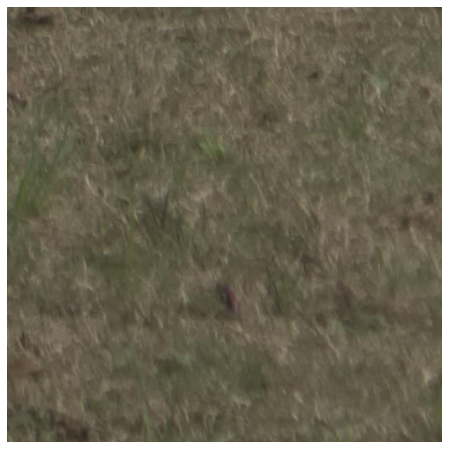

In [ ]:
image, target = train_dataset[0]
numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
ax.set_axis_off()
ax.imshow(numpy_image);

Confusion Matrix


In [ ]:
import warnings

warnings.filterwarnings("ignore")


class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        
        self.base_dir = './'
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, mode='min',
        factor=0.6,
        patience=2,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08)
        #label smoothing was added for improve accuracy and avoid overconfidence
        self.criterion = LabelSmoothing().to(self.device)
        #swapping out label smoothing
        # self.criterion = torch.nn.functional.cross_entropy
        self.log(f'Parameters set. Device is {self.device}')
    
      

    def fit(self, train_loader, validation_loader):
        print("Fit funtion")
        for e in range(self.config.n_epochs):
            # if self.config.verbose:
            #     lr = self.optimizer.param_groups[0]['lr']
            #     timestamp = datetime.utcnow().isoformat()
            #     self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, final_scores = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, final_scores = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()
        for step, (images, targets) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    
                    print(
                        F'Val Step {step}/{len(val_loader)}, ' + \
                        F'summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        F'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                targets = targets.to(self.device).float()
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                final_scores.update(targets, outputs)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss, final_scores

    def train_one_epoch(self, train_loader):
        y =[]
        preds=[]
        print("one epoch")
        self.model.train()
        summary_loss = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()
        for step, (images, targets) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print("verbose")
                    print(
                        F"Train Step {step}/{len(train_loader)}, " + \
                        F"summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, " + \
                        F"time: {(time.time() - t):.5f}', end='\r"
                    )
            #print("train")
            targets = targets.to(self.device).long()
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            # print("batch_size ",batch_size)

            self.optimizer.zero_grad()
            outputs = self.model(images)
         
            # print("output ",outputs)
            # print("target",targets)
            y.extend(targets.cpu().numpy().astype(int))
            preds.extend(nn.functional.softmax(outputs, 1).data.cpu().numpy())
            # print("data", nn.functional.softmax(outputs, 1).data.cpu().numpy())
            # print("detach",nn.functional.softmax(outputs, 1).detach().cpu().numpy())
            # y = np.array(y)
            # all_labels=y.copy()
            # print("alllabels",all_labels)
            # preds = np.array(preds)
            # print(preds.argmax(1))
            # print("preds",preds[0])
            loss = self.criterion(outputs, targets)
            loss.backward()
            
            final_scores.update(targets, outputs)
            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        ##Attempt to get a proper confusion matrix
        y = np.array(y)
        all_labels=y.copy()
        preds = np.array(preds)
        #rename preds
        confusion_mat = sklearn.metrics.confusion_matrix(all_labels.argmax(1), preds.argmax(1))
        plt.figure(figsize=(30,9))
        foo = plot_confusion_matrix(confusion_mat, classes=classNames, normalize=True,
                      title='Confusion matrix')
        
        print(preds)


        return summary_loss, final_scores
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [ ]:
#MixNet
!pip install timm
import timm
# from inplace_abn.abn import InPlaceABN
class MobileVNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
          #adding the back bone 
        # self.backbone = backbone
        self.model = timm.create_model('mobilenetv3_rw', pretrained=True)
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.linear= nn.Linear(in_features=1280, out_features=4, bias=True)

        
        print(self.model)

        
      
      
     

    def forward_backbone(self, x):
        return get_feature_of(self.model, x)

    def forward(self, x):
        features = self.model.forward_features(x)
        # x = F.relu(features, inplace=True)
        #x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.avg_pool(features).reshape(x.shape[0], -1)
        # x = torch.flatten(x, 1)
        # x = self.classifier(x)
        return self.linear(x)


In [ ]:
# num_classes=1000
# in_channels=3
# modelName= "efficientnet-b2"
# model = EfficientNet.from_name(
#                 model_name="efficientnet-b2",
#                  override_params={"num_classes": num_classes},
#             )
import torchvision
import sys
class Identity(nn.Module):
  def __init__(self):
    super(Identity,self).__init__()
  def forward(self,x):
    return x

def get_net():
 
  #efficientNet
    # net = Model(4,'efficientnet-b2')
    #densenet
    # net=DenseModel(4,'densenet-b2')
    net = MobileVNet()
  
#    net._fc = nn.Linear(in_features=1408, out_features=4, bias=True)

    return net

net = get_net().cuda()
#net = get_net()
print(net)

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): HardSwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(

Ensemble

In [ ]:
# from inplace_abn.abn import InPlaceABN
from efficientnet_pytorch import EfficientNet
class Ensemble(torch.nn.Module):
    def __init__(self):
        super().__init__()
          #adding the back bone 
        # self.backbone = backbone
        self.mobilenet =timm.create_model('mobilenetv3_rw', pretrained=True)
        self.mixnet =  self.model = timm.create_model('mixnet_s', pretrained=True)
        self.efficientNet = EfficientNet.from_pretrained("efficientnet-b2")
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.linear= nn.Linear(in_features=1280+1536, out_features=4, bias=True)

        

        
      
      
     

    def forward_backbone(self, x):
        return get_feature_of(self.model, x)

    def forward(self, x):
        featuresMixnet = self.mixnet.forward_features(x)
        featuresMixnet = self.avg_pool(featuresMixnet).reshape(x.shape[0], -1)
        featuresEffNet = self.efficientNet.extract_features(x)
        featuresEffNet = self.avg_pool(featuresEffNet).reshape(x.shape[0], -1)
        x =torch.cat((featuresMixnet,featuresEffNet),dim=1)
        # x = F.relu(features, inplace=True)
        #x = F.adaptive_avg_pool2d(x, (1, 1))
       # x = self.avg_pool(features).reshape(x.shape[0], -1)
        # x = torch.flatten(x, 1)
        # x = self.classifier(x)
        return self.linear(x)

In [ ]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(6, 12, 3, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(12, 36, 3, stride=1, padding=1, bias=False)
        self.mybn1 = nn.BatchNorm2d(6)
        self.mybn2 = nn.BatchNorm2d(12)
        self.mybn3 = nn.BatchNorm2d(36)

        self.enet = timm.create_model('efficientnet_b0', pretrained=True)
        self.enet.conv_stem.weight = nn.Parameter(self.enet.conv_stem.weight.repeat(1, 12, 1, 1))

        self.dropout = nn.Dropout(0.5)
        self.enet.blocks[5] = nn.Identity()
        self.enet.blocks[6] = nn.Sequential(
            nn.Conv2d(self.enet.blocks[4][2].conv_pwl.out_channels, self.enet.conv_head.in_channels, 1),
            nn.BatchNorm2d(self.enet.conv_head.in_channels),
            nn.ReLU6(),
        )
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        x = F.relu6(self.mybn1(self.conv1(x)))
        x = F.relu6(self.mybn2(self.conv2(x)))
        x = F.relu6(self.mybn3(self.conv3(x)))
        x = self.enet(x)
        return x

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(self.dropout(x))
        return x

In [ ]:
#net=Ensemble()
net=enetv2("efficientnet_b0",4)
net = get_net().cuda()

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): HardSwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(

In [ ]:
class TrainGlobalConfig:
    num_workers = 4
    batch_size = 10
    n_epochs = 1
    lr = 0.001

    # -------------------
    verbose = True
    verbose_step = 100
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    
    # --------------------

In [ ]:
!pip install catalyst
from catalyst.data.sampler import BalanceClassSampler
def run_training():
    device = torch.device('cuda:0')

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        batch_size=TrainGlobalConfig.batch_size,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
#     fitter.load(f'{fitter.base_dir}/last-checkpoint.bin')
    fitter.fit(train_loader, val_loader)

Parameters set. Device is cuda:0
Fit funtion
one epoch
verbose
Train Step 0/24000, summary_loss: 0.00000, final_score: 0.00000, time: 0.46193', end='
verbose
Train Step 100/24000, summary_loss: 1.43169, final_score: 0.57207, time: 13.21029', end='
verbose
Train Step 200/24000, summary_loss: 1.39974, final_score: 0.60714, time: 24.94963', end='
verbose
Train Step 300/24000, summary_loss: 1.38605, final_score: 0.61734, time: 36.63276', end='
verbose
Train Step 400/24000, summary_loss: 1.37062, final_score: 0.62329, time: 48.27036', end='
verbose
Train Step 500/24000, summary_loss: 1.36515, final_score: 0.62972, time: 59.90809', end='
verbose
Train Step 600/24000, summary_loss: 1.35457, final_score: 0.63506, time: 71.56526', end='
verbose
Train Step 700/24000, summary_loss: 1.34888, final_score: 0.63956, time: 83.36723', end='
verbose
Train Step 800/24000, summary_loss: 1.34400, final_score: 0.64300, time: 95.11991', end='
verbose
Train Step 900/24000, summary_loss: 1.33618, final_score: 

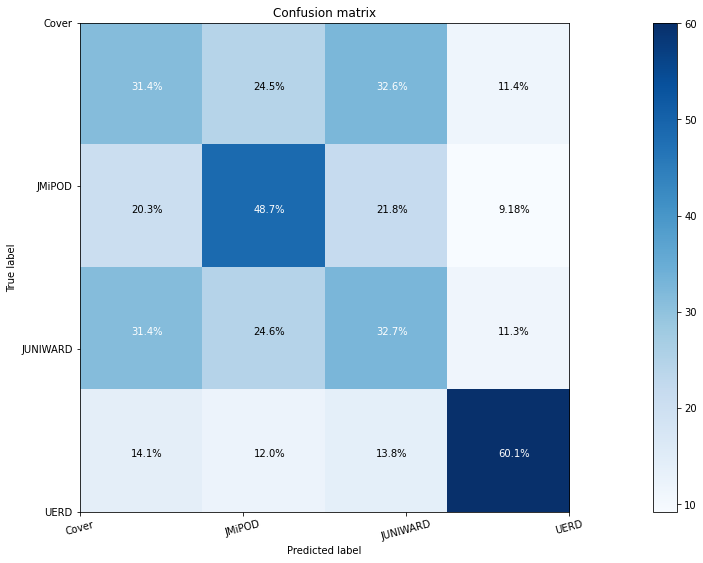

In [ ]:
run_training()

In [ ]:
#copy 
# !cp ./last-checkpoint.bin ./last-checkpoint2.bin
!cp ./last-checkpoint.bin ./drive/MyDrive/weights/ 